# Image Denoising with Metropolis Hastings MCMC

## Our Goal

![lena_denoised](./figures/lena_denoised.png "Lena Denoised")



### \~\~\~\~\~\~\~ SPOILER START - The End of the Project \~\~\~\~\~\~\~

\begin{eqnarray}
\exp{\left( - 2\gamma Z^{(t)}_{ij} X_{ij} - 2\beta \sum_{(i,j) \sim (k,l)} Z^{(t)}_{ij} Z^{(t)}_{kl} \right)}
\end{eqnarray}


In [ ]:
beta, pi  = 0.8, 0.15
gamma = 0.5*np.log((1-pi)/pi)
T = 5000000

Z = X.copy()
for t in range(T):
    i,j = np.random.choice(I), np.random.choice(J)
    delta_E = -2*gamma*X[i,j]*Z[i,j] -2*beta*Z[i,j]*(np.sum(Z[max(i-1,0):i+2,max(j-1,0):j+2]) - Z[i,j])
    if np.log(np.random.rand()) < delta_E:
        Z[i,j] = - Z[i,j]

### \~\~\~\~\~\~\~ SPOILER END - The End of the Project \~\~\~\~\~\~\~


# What Do We Know?

![lena_denoised](./figures/lena_denoised.png "Lena Denoised")

### Noise

Obviously, the image is **noisy**. It means that, we have a degenerate version of the real image.

But somehow, our ***ELF EYES*** can see the real image behind the noisy one!!!! How is this possible?

Actually, knowingly or unknowingly, we have a **model for the original image** in our heads.

So, we need to find a way to tell the computer, what our assumption for the real image is.

### The Ising Model


* *The Ising model* models things that have two states (+1 or -1)
* Things interact with its neighbors

If we assume that our original black and white image is generated using The Ising model, then it means that ***if we take random black pixel from the image, it is more likely that this pixel is surrounded by black pixels (same for the white pixels).*** This is all we need to know about The Ising model.

![Ising](./figures/Ising.gif "Ising")

# The Model

![lena_denoised](./figures/lena_denoised.png "Lena Denoised")

* There is a black and white image $Z$ that we represent its pixels with $+1$ and $-1$ (i.e. black or white). We don't have this image and this is the image that we want to achieve. 
* There is another black and white image $X$. This is the **noisy** version of $Z$. By noisy we mean that, **some of the pixels of the image $Z$ are flipped**. We start with this noisy image $X$, and try to reach the noise-free image $Z$.
* We assume that the image $Z$ is generated from an **Ising model**.

![Ising Model MRF](./figures/Ising_MRF.png "Ising Model MRF")

Before proceeding to the next step, wee need to revise two steps:
* There is a black and white image $Z$ that we represent its pixels with $+1$ and $-1$ (i.e. black or white). We don't have this image and this is the image that we want to achieve. 
* There is another black and white image $X$. This is the noisy version of $Z$. By noisy we mean that, some of the pixels of the image $Z$ are flipped. We start with this noisy image $X$, and try to reach the noise-free image $Z$. **We will assume that, the probability of a random flip is $\pi$. If $\pi = 0.1$ then ten percent of the pixels of $Z$ will be flipped to achieve the noisy image $X$.**
* We assume that the image $Z$ is generated from an Ising model. **There is a parameter called $\beta$ which indicates how much we rely on The Ising Model. We expect more consistency between the neighbouring pixels if $\beta$ is higher.**

## Combining What We Got

* By combining all these 3 information, we can statistically show our model as $p(Z \mid X, \beta, \pi)$. It can be read as the probability of $Z$ given $X$, $\beta$ and $\pi$.
* It returns a **score** for a candidate $Z$ image that we propose.
  * The score is higher if the candidate image is more likely to the original image (or more fit to the model). 
  * It is a distribution over all possible $Z$ images. Actually all possible images!
  * We want to find the **most probable $Z$ image**, in another words the $Z$ image that gives the highest score from the posterior probability.

\begin{eqnarray}
p(Z \mid X, \beta, \pi) 
& \propto & \exp{\left( \gamma \sum_{ij} Z_{ij} X_{ij} + \beta \sum_{(i,j)\sim (k,l)} Z_{ij} Z_{kl} \right)}
\end{eqnarray}

where $\gamma = \dfrac{1}{2} \log{\dfrac{1-\pi}{\pi}}$. In this formulation, higher $\gamma$ implies lower noise on the $X$. Similarly, we expect more consistency between the neighbouring pixels if $\beta$ is higher.

Notice that, the summation is over the all the pixels $Z_{kl}$ that are connected to a fixed $Z_{ij}$.

### The Problem
  
* However, this is not straight forward process because the posterior probability doesn't have a close form like Gaussian. Thus we can't find the most probable image easily.
* We have to try all possible $Z$ images, but this is not efficient due to that there are $2^{I \times J}$ possibilities.
* Do we give up then? Of course not! Instead of finding the original image in an instant, we will approach to it step by step.

# Metropolis-Hastings Markov Chain Monte Carlo

* We have a function (the **posterior distribution**) that tells us **which candidate $Z$ image is more similar to the original image**.
* Instead of  choosing random images, it is obvious that we should **start with the image $X$** which is the only thing that is given to us.
* To reach the noise free image $Z$ we need to make some modification to $X$:
 1. Choose a random pixel from the image $X$
 2. Flip this pixel if the posterior function of the flipped image has a higher score.
 3. Repeat this process untill it converges.
 
This method seems good but, there is a small flaw here. We are always flipping the pixel if it is better. It is like a **Greedy Apporach**.

However we may want to *flip a pixel even if it may not result a better image*. Why do we want this? **To explore more possibilities**. 
 
* **Metropolis-Hastings MCMC algorithm**:
 1. Choose a random pixel from the image $X$
 2. Calculate an **acceptance probability** of flipping the pixel or not.
 3. Flip this pixel with the probability of the acceptance probability that is calculated in the second step.
 4. Repeat this process untill it converges.

### Acceptance Probability

We will calculate it by dividing the posterior distributions of two possibilities (flipping or not):

Assume a bit flip is proposed in pixel $(i,j)$ at time step $t$, (a bit flip on $Z^{(t)}_{ij}$, i.e. $Z'_{ij} \gets -Z^{(t)}_{ij} $), then

\begin{eqnarray}
\alpha^{(t)} 
& = & 
\frac{p(Z' \mid X, \beta, \pi)}{p(Z^{(t)} \mid X, \beta, \pi)} \\
& = & 
\exp{\left( - 2\gamma Z^{(t)}_{ij} X_{ij} - 2\beta \sum_{(i,j) \sim (k,l)} Z^{(t)}_{ij} Z^{(t)}_{kl} \right)}
\end{eqnarray}


* At the end, we will flip the pixel with this **acceptance probability**.
* If this ratio is bigger than 1, which means the flipping generates a better image, then we directly accept and flip.
* If this ratio is between 0 and 1, which means the flipping generates a worse image, then we flip the pixel with the calculated acceptance probability.

## Pseudocode

1. Initialize your $\beta$ and $\pi$ priors. Then $\gamma = \dfrac{1}{2} \log{\dfrac{1-\pi}{\pi}}$   
2. Initialize $Z^{(0)} \gets X$   
3. At time step $t$:   
    3.1. Randomly choose a pixel $(i,j)$.    
    3.2. Propose a bit flip on $Z^{(t)}_{ij}$, i.e. $Z'_{ij} \gets -Z^{(t)}_{ij} $.   
    3.3. Calculate acceptance probability    
    $\alpha^{(t)} = \min\left\{ 1 , \frac{p(Z' \mid X, \beta, \pi)}{p(Z^{(t)} \mid X, \beta, \pi)} \right\}$    
    3.4. $Z^{(t+1)} \gets Z'$, with probability $\alpha^{(t)}$   
    3.5. $Z^{(t+1)} \gets Z^{(t)}$, otherwise   

![IMH_MCMC_demo](./figures/MH_MCMC_demo.png "MH_MCMC_demo")

# LET'S CODE

In [6]:
%matplotlib inline
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import imageio

from pylab import rcParams
rcParams['figure.figsize'] = 6, 6

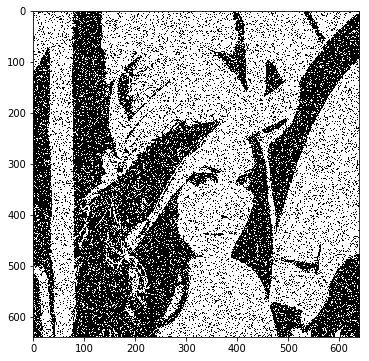

In [20]:
# Reading image from the text
X = np.loadtxt("./figures/lena_noisy.txt")
plt.imshow(X,cmap='gray',vmin=-1,vmax=1)
plt.show()

In [4]:
X

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -1.,  1.],
       [ 1.,  1.,  1., ..., -1.,  1.,  1.],
       ...,
       [ 1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1.,  1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [42]:
beta, pi  = 0.8, 0.15 # for arbitrary parameters that reflects our prior belief
gamma = 0.5*np.log((1-pi)/pi)

T = 5000000 # sufficient number of steps to converge stationary distribution

In [43]:
Z = X.copy() # Initialize Z from X 
for t in range(T):
    i,j = np.random.choice(I), np.random.choice(J) # randomly choose a coordinate (i,j)
    
    # Calculate acceptance propability
    # We don't take exponential. Instead, we take the log of random number. This is more stable.
    delta_E = -2*gamma*X[i,j]*Z[i,j] -2*beta*Z[i,j]*(np.sum(Z[max(i-1,0):i+2,max(j-1,0):j+2]) - Z[i,j])
    
    # We also don't deal with minimum function for acceptance probability
    #   because we don't need to cast it to 1 if it is higher.
    
    # Flip the pixel if accepted
    if np.log(np.random.rand()) < delta_E:
        Z[i,j] = - Z[i,j] # Update the image

\begin{eqnarray}
\alpha^{(t)} 
& = & 
\exp{\left( - 2\gamma Z^{(t)}_{ij} X_{ij} - 2\beta \sum_{(i,j) \sim (k,l)} Z^{(t)}_{ij} Z^{(t)}_{kl} \right)}
\end{eqnarray}

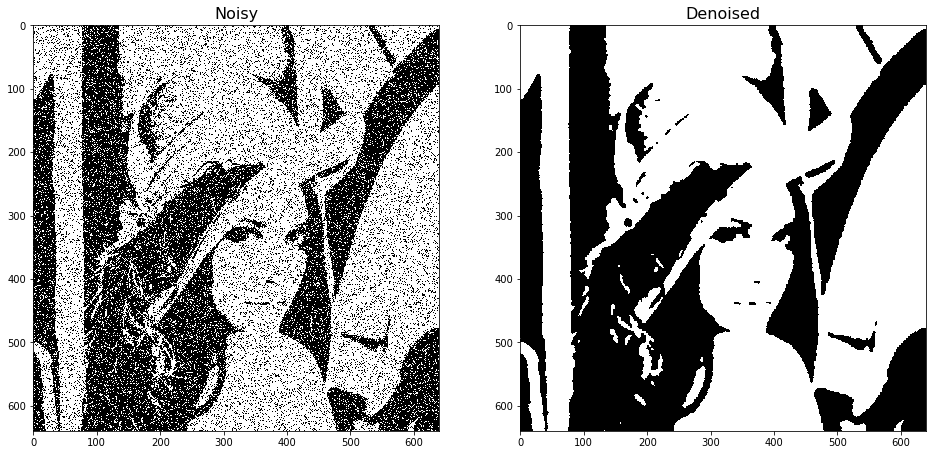

In [44]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].imshow(X,cmap='gray',vmin=-1,vmax=1)
ax[0].set_title("Noisy", fontsize=16)
ax[1].imshow(Z,cmap='gray',vmin=-1,vmax=1)
ax[1].set_title("Denoised", fontsize=16)
plt.show()

## Scripts

#### image_to_text.py

In [11]:
import sys
from PIL import Image
import numpy as np

#filepath = sys.argv[1]
filepath = "figures/lena.png"

imgX = Image.open(filepath)
imgX = imgX.convert('L')
img = np.asarray(imgX)
img = 2*(img > 128).astype(int)-1

#file = open(sys.argv[2], "w")
file = open("outO.txt", "w")

txt = list(img)
for i in txt:
    for j in i:
        file.write(str(j) + " ")
    file.write('\n')
file.close()

#### make_noise.py

In [12]:
import sys
import numpy as np

#img = np.loadtxt(sys.argv[1])
img = np.loadtxt("outO.txt")

#pi = float(sys.argv[2])
pi = float(0.15)

I,J = img.shape
flip = np.random.rand(I,J) < pi
X = img * (-1)**flip

#file = open(sys.argv[3], "w")
file = open("outN.txt", "w")

txt = list(X)
for i in txt:
    for j in i:
        file.write(str(int(j)) + " ")
    file.write('\n')
file.close()

#### text_to_image.py

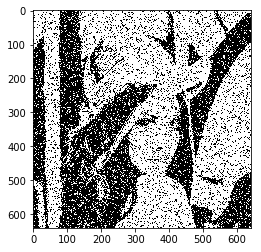

In [13]:
import sys
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
import imageio

#filepath = sys.argv[1]
filepath = "outN.txt"

img = np.loadtxt(filepath)

#imageio.imwrite(sys.argv[2], img)
imageio.imwrite("outI.png", img)

plt.imshow(img,cmap='gray',vmin=-1,vmax=1)
plt.show()

## Example
Takes the original image as input. You can give any kind of image as input (Color or BW)

In [10]:
%matplotlib inline
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 6, 6

### Original Image

In [22]:
imgX = Image.open("./figures/lena.png")  # open colour image
imgX = imgX.convert('L')
img = np.asarray(imgX)
img = 2*(img > 128).astype(int)-1

In [12]:
img

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

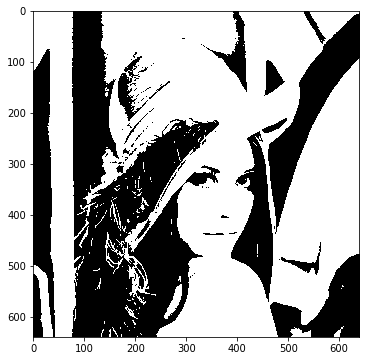

In [13]:
plt.imshow(img,cmap='gray',vmin=-1,vmax=1)
plt.show()

### Noisy Image

In [14]:
pi = 0.15
I,J = img.shape
flip = np.random.rand(I,J) < pi
X = img * (-1)**flip

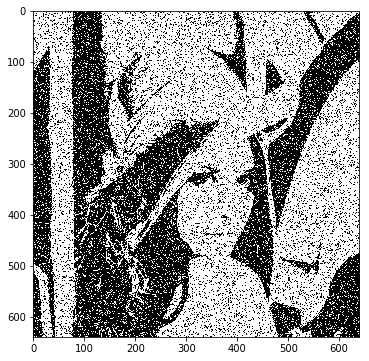

In [15]:
plt.imshow(X,cmap='gray',vmin=-1,vmax=1)
plt.show()

## Image Denoising

We will sample a $Z$ from the posterior distribution. Hopefully, it will appear as denoised.

In [16]:
beta, pi  = 0.8, 0.15 # for arbitrary parameters that reflects our prior belief
gamma = 0.5*np.log((1-pi)/pi)

T = 5000000 # sufficient number of steps to converge stationary distribution

In [17]:
Z = X.copy() # Initialize Z from X 
for t in range(T):
    i,j = np.random.choice(I), np.random.choice(J) # randomly choose a coordinate (i,j)
    
    # Calculate acceptance propability
    # We don't take exponential. Instead, we take the log of random number. This is more stable.
    delta_E = -2*gamma*X[i,j]*Z[i,j] -2*beta*Z[i,j]*(np.sum(Z[max(i-1,0):i+2,max(j-1,0):j+2]) - Z[i,j])
    
    # We also don't deal with minimum function for acceptance probability
    #   because we don't need to cast it to 1 if it is higher.
    
    # Flip the pixel if accepted
    if np.log(np.random.rand()) < delta_E:
        Z[i,j] = - Z[i,j] # Update the image

## Result

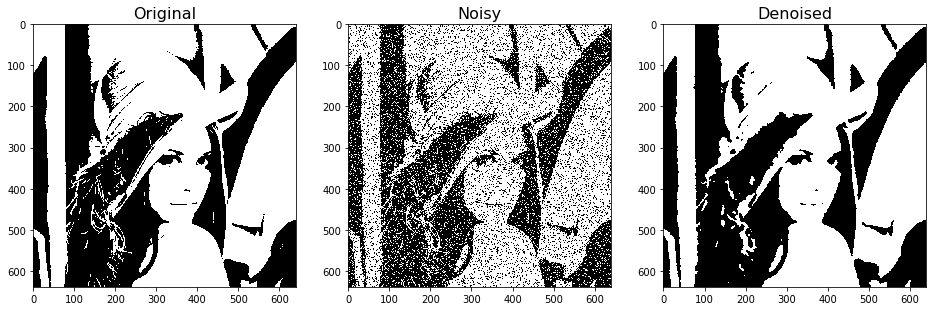

In [19]:
fig, ax = plt.subplots(1,3, figsize=(16,8))
ax[0].imshow(img,cmap='gray',vmin=-1,vmax=1)
ax[0].set_title("Original", fontsize=16)
ax[1].imshow(X,cmap='gray',vmin=-1,vmax=1)
ax[1].set_title("Noisy", fontsize=16)
ax[2].imshow(Z,cmap='gray',vmin=-1,vmax=1)
ax[2].set_title("Denoised", fontsize=16)
plt.show()